In [47]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split as cv_split
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
d_f = pd.read_csv("out_data/chicago_features.csv")

d_f.Beat = d_f.Beat.astype("float")
d_f = d_f.rename(columns={"Beat":"beat_num"})
pop_dict = dict(zip(pop_den.beat_num, pop_den.density))
pop_dict = {float(k):float(v) for k,v in pop_dict.items()}
map_den = []
for i in d_f.beat_num:
    try:
        map_den.append(pop_dict[i])
    except KeyError:
        map_den.append(np.nan)

d_f["density"] = map_den
drop_df = d_f.drop(["Date", "Block", "Second"], axis=1)
loc_type = drop_df.groupby("Location Description").count()["beat_num"].sort_values(ascending=False)[:20].index
loc_type = list(loc_type) + ["OTHER"]
drop_df.loc[~drop_df["Location Description"].isin(loc_type), "Location Description"] = loc_type[-1]
drop_df["Location Description"].unique()

In [ ]:
final_feature = drop_df.copy()
for i in final_feature.columns:
    if final_feature[i].dtype == "object":
         # transform all the non-categorical data to categorical
        final_feature[i] = pd.Categorical(final_feature[i]).codes        

In [340]:
final_feature.head()

,beat_num,District,Primary Type,Ward,Location Description,Community Area,Year,Month,Day,Dow,Hour,Minute,Latitude,Longitude,density
0,1733.0,17.0,0,NaN,1,NaN,2002,3,29,4,2,3,41.950828,-87.700595,16098.316169
3,2233.0,22.0,0,NaN,15,NaN,2002,3,22,4,22,15,41.689957,-87.637461,8854.443163
5,1423.0,14.0,0,NaN,10,NaN,2002,3,28,3,22,40,41.907430,-87.692053,15541.058791
7,513.0,5.0,0,NaN,7,NaN,2002,3,23,5,21,21,41.698567,-87.628056,8000.720559
8,934.0,9.0,4,NaN,18,NaN,2002,3,29,4,3,25,41.794670,-87.631785,10067.208215


In [341]:
final_feature.dropna(how="any", inplace=True) # throw away the nan value

#### First use GridSearchCV to tune the parameters

In [336]:
cv_params = {'max_depth': [3,5,7],
             'n_estimators': [300, 500, 700],
             'colsample_bytree':[0.1, 0.4, 0.7, 0.8 ]}
ind_params = {'learning_rate': 0.1,
              'seed':2017, 
              'subsample': 0.8, 
              'objective': 'multi:softprob',
              }
# use gridsearchcv to choose the best parameters
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = "accuracy", cv = 5, n_jobs = -1) 

In [342]:
y = final_feature.pop("Primary Type")

In [343]:
final_feature.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
y = pd.DataFrame(y)

In [345]:
X_train, X_test, y_train, y_test = cv_split(final_feature, y, random_state=2017, test_size=0.2)

In [359]:
optimized_GBM.fit(X_train, np.reshape(y_train.values, [y_train.shape[0], ]))

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=2017, silent=True, subsample=0.8),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [300, 500, 700], 'colsample_bytree': [0.1, 0.2, 0.3, 0.4], 'max_depth': [3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [360]:
optimized_GBM.best_estimator_

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.4,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=700, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=2017, silent=True, subsample=0.8)

In [367]:
optimized_GBM.best_params_

{'colsample_bytree': 0.4, 'max_depth': 7, 'n_estimators': 700}

In [370]:
xgdmat = xgb.DMatrix(X_train, y_train)

In [371]:
our_params = {'max_depth': 7,
              'n_estimators':700,
              'colsample_bytree':0.4,
              'eta':0.1,
              'seed':2000,  
              'objective': 'multi:softprob',
              'min_child_weight': 1,
              'subsample':0.8,
              'num_class':5
             }

#### Use cross validation to find the best boost round

In [373]:
cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
                metrics = ['mlogloss'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 100) # Look for early stopping that minimizes error

In [375]:
cv_xgb.shape

(1565, 4)

#### From the last cell we can see that the best round to run is 1565

In [376]:
final_gb = xgb.train(our_params, xgdmat, num_boost_round = 1565)

#### Plot the feature importance

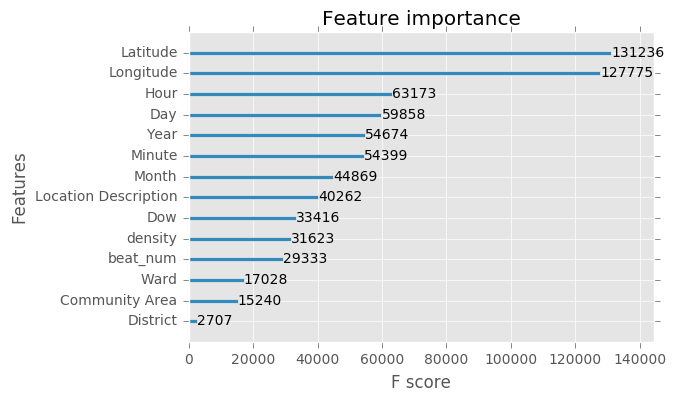

In [382]:
xgb.plot_importance(final_gb)

In [377]:
testdmat = xgb.DMatrix(X_test)
y_pred = final_gb.predict(testdmat)

In [380]:
from sklearn.metrics import log_loss, accuracy_score
print ("the log_loss is %f" %(log_loss(y_test, y_pred)))
print ("the accuracy is %f" %(accuracy_score(np.argmax(y_pred, axis=1), y_test)))

the log_loss is 0.630975
the accuracy is 0.735059
